### Weights & Biases login

In [1]:
!wandb login

wandb: Currently logged in as: spattni. Use `wandb login --relogin` to force relogin


In [2]:
import wandb
import torch
import numpy as np
import matplotlib.pyplot as plt
from lstm_backend import CryptoDataset, LSTMRNN, LSTMBackend

## Data Preparation

In [3]:
lstm_backend = LSTMBackend(data_path='BTC.feather')
lstm_backend.load_data()

## Model Define & Train

In [7]:
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [100,250,1000]
        },
        'learning_rate': {
            'values': [1e-2, 1e-3, 1e-4, 3e-4, 3e-5, 1e-5]
        },
        'optimizer': {
            'values': ['adam', 'sgd', 'rmsprop']
        },
        'hidden_layers': {
            'values': [2,3,4,5,6]
        },
        'num_layers': {
            'values': [1,2,3]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project='Crypto_Sweep')

In [8]:
wandb.agent(sweep_id, lstm_backend.train_model, count=10)

wandb: Currently logged in as: spattni. Use `wandb login --relogin` to force relogin


100%|██████████| 2000/2000 [22:42<00:00,  1.47it/s]


train/train_accuracy,▁▇██████████████████████████████████████
train/train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_accuracy,▁▇██████████████████████████████████████
val/val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/train_accuracy,0.9943
train/train_loss,0.0
val/val_accuracy,0.99348
val/val_loss,0.0


In [23]:
# ----- SAVE MODEL ----- #
torch.save(model.state_dict(), 'btc_lstm.pt')

## Model Inference

### Inference on Full Dataset (with Train/Test segregation)

In [12]:
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,SMA_7,SMA_25,SMA_99,buy
0,1.503295e+09,2017-08-21 06-AM,BTC/USDT,4016.90,4032.01,3953.40,0.016191,66.49,265785.06,4067.44571,4114.0812,4180.18495,0
1,1.503299e+09,2017-08-21 07-AM,BTC/USDT,3982.96,4055.92,3970.63,0.017114,49.19,197915.55,4058.21000,4111.2100,4177.50616,0
2,1.503302e+09,2017-08-21 08-AM,BTC/USDT,4043.63,4055.92,4010.78,0.017002,54.73,220805.54,4049.88143,4106.4272,4174.68778,0
3,1.503306e+09,2017-08-21 09-AM,BTC/USDT,4036.30,4077.07,4035.82,0.017576,3.89,15774.01,4049.03286,4101.9980,4172.15899,0
4,1.503310e+09,2017-08-21 10-AM,BTC/USDT,4074.00,4088.12,4066.00,0.017791,5.09,20748.78,4049.51000,4099.3220,4169.51364,0


Accuracy: 90.36%


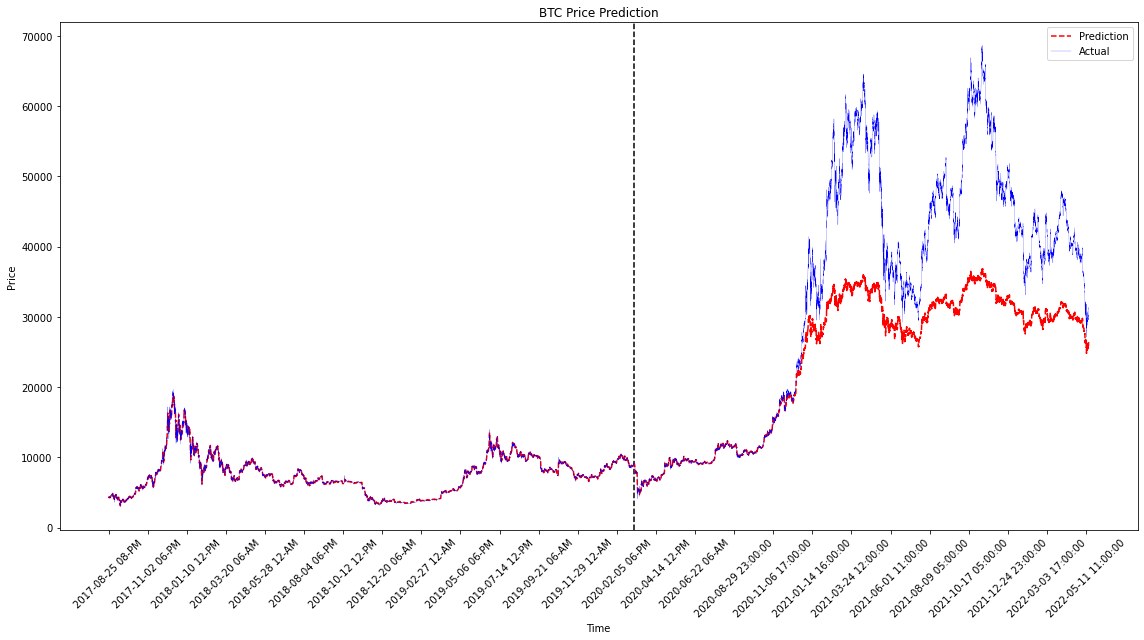

In [72]:
# ---- TESTING ---- #
pred, acc = evaluate_model(model, full_dl)
# print(f'{df.shape[0] - len(pred)}')
data_predict = scaler.inverse_transform(pred)
y_all_plot = scaler.inverse_transform(y_all)
_, ax = plt.subplots(figsize=(16,9))
plt.axvline(x=X_train.shape[0], color='k', linestyle='--')
ax.plot(data_predict, '--', label='Prediction', color='r')
ax.plot(y_all_plot, label='Actual', color='b', linewidth=0.2)
dates = list(df.iloc[L:].date) # Spaced by L
ax.set_xticks(np.arange(0, data_predict.shape[0], L*15))
ax.set_xticklabels(dates[::L*15], rotation=45)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('BTC Price Prediction')
plt.legend()
plt.tight_layout()
print(f'Accuracy: {acc*100:,.2f}%')
plt.show()

In [64]:
y_all_plot.shape[0] == data_predict.shape[0]

True

### Inference on Test Data Only

Accuracy: 73.87%


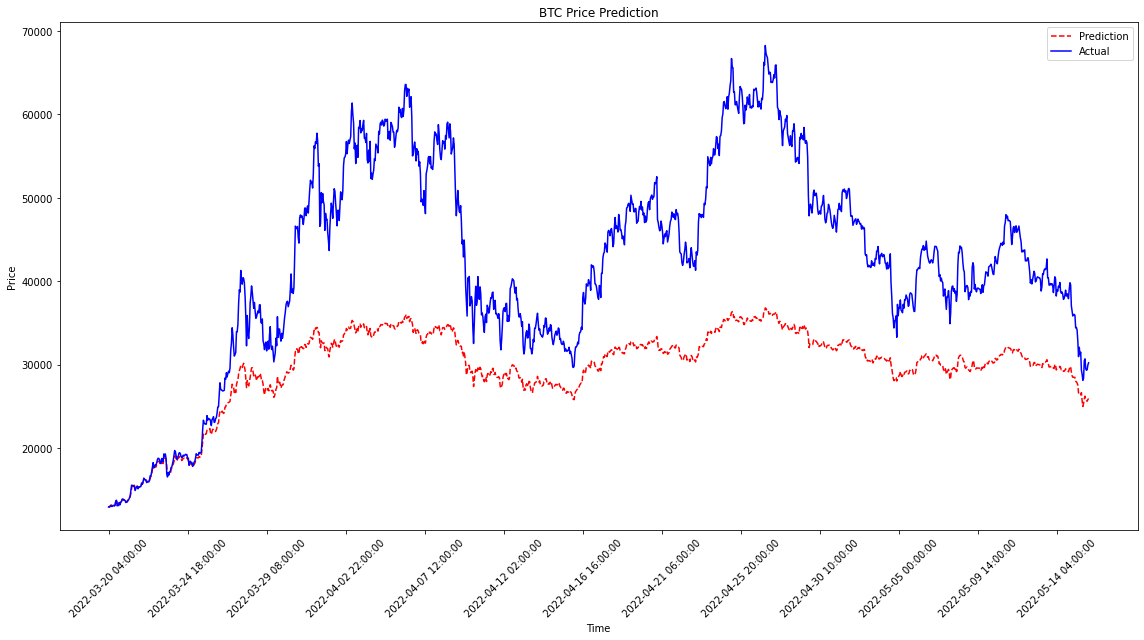

In [90]:
# ---- TESTING ---- #
pred, acc = evaluate_model(model, test_dl)
data_predict = scaler.inverse_transform(pred)
y_all_plot = scaler.inverse_transform(y_test)
_, ax = plt.subplots(figsize=(16,9))
ax.plot(data_predict[::10], '--', label='Prediction', color='r')
ax.plot(y_all_plot[::10], label='Actual', color='b')
plt.xlabel('Time')
plt.ylabel('Price')
dates = list(df.iloc[-data_predict[::10].shape[0]:].date) # Spaced by L
ax.set_xticks(np.arange(0, data_predict[::10].shape[0], L))
ax.set_xticklabels(dates[::L], rotation=45)
plt.title('BTC Price Prediction')
plt.legend()
plt.tight_layout()
print(f'Accuracy: {acc*100:,.2f}%')
plt.show()